# Exercise 8.4 (programming) 
The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa\sqrt{\tau}$ was used not in updates, but solely in action seplection. That is, suppose the action selected was always that for which $Q(S_t, a) + \kappa\sqrt{\tau(S_t, a)}$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach.

## We repeat a similar expriment as in Example 8.2: Blocking Maze. 

The left environment was used for the first $1000$ steps and the right environment for the rest.

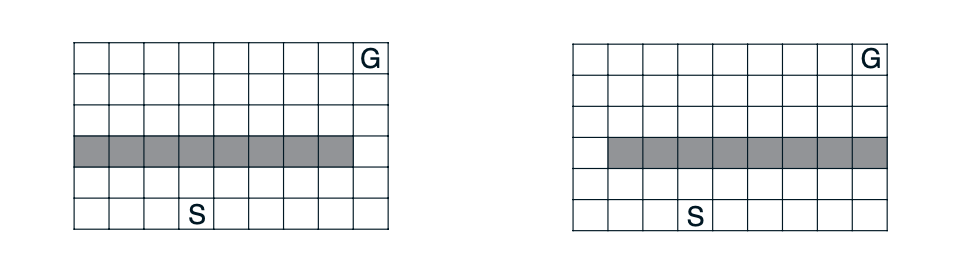

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

In [2]:
class Environment:
    def __init__(self, size, startpoint, endpoint, actions, maze_walls):
        self.m, self.n = size
        self.actions = actions
        self.endpoint = endpoint
        self.startpoint = startpoint
        self.maze_walls = maze_walls

    def step(self, position, action):
        if action not in self.actions:
            raise NameError("The action (%s,%s) is not allowed!!" %action)
        reward = 0
        Done = False
        r, c = position
        a, b = action
        new_r, new_c = r-a, c+b
        if ((new_r, new_c) in self.maze_walls 
            or new_c > self.n-1 
            or new_c < 0 
            or new_r > self.m-1 
            or new_r < 0):
            return position, 0, False
        if (new_r, new_c) == self.endpoint:
            Done = True
            reward = 1
        return (new_r, new_c), reward, Done

In [3]:
Arrow = {}
Arrow[(0,0)] = '.'
Arrow[(0,-1)] = '\u2190' #Leftwards Arrow
Arrow[(1,0)] = '\u2191' #Upwards Arrow
Arrow[(0,1)] = '\u2192' #Rightwards Arrow
Arrow[(-1,0)] = '\u2193' #Downwards Arrow
Arrow[(1,-1)] = '\u2196' #North West Arrow
Arrow[(1,1)] = '\u2197' #North East Arrow
Arrow[(-1,1)] = '\u2198' #South East Arrow
Arrow[(-1,-1)] = '\u2199' #South West Arrow

In [4]:
class Model:
    def __init__(self):
        self.table = {}
  
    def set_table(self, table):
        self.table = table

    def update(self, s_0, a, s_1, r, Done):
        if s_0 not in self.table.keys():
            self.table[s_0] = {}
            self.table[s_0][a] = (s_1, r, Done)
        else:
            self.table[s_0][a] = (s_1, r, Done)

    def step(self):
        StateList = [key for key in self.table.keys()]
        ind = np.random.choice(range(len(StateList)))
        state = StateList[ind]
        ActionList = list(self.table[state].keys())
        ind = np.random.choice(range(len(ActionList)))
        action = ActionList[ind]
        next_state, reward, Done = self.table[state][action]
        return  state, action, next_state, reward, Done

In [5]:
class Maze:
  def __init__(self, Env, Envmodel, 
               n_iters = 100, n_planning_steps = 0,
               gamma = 1, eps = .1, alpha = .1, 
               Type = 'Dyna-Q', k = 0, change_step = 1000, plot = True):
    
    if Type == 'Dyna-Q':
        self.title = 'Tabular ' + Type
    elif Type == 'Dyna-Q+':
        self.title = 'Tabular ' + Type + '\n (k = ' + str(k) +')'
    elif Type == 'New Dyna-Q+':
        self.title = 'Tabular ' + Type + '\n (k = ' + str(k) +')'
    else:
        raise NameError("Valid types are Dyna-Q, Dyna-Q+, and New Dyna-Q+")
        
    self.model = Envmodel
    self.Env = Env
    self.actions = Env.actions
    self.Q = {}
    self.len_episodes_hist = np.zeros(n_iters)
    self.reward_history = []
    self.last_visit_time = {}
    self.table = {}
    self.k = k
    self.time_step = 0
    
    for x in range(self.Env.m):
      for y in range(self.Env.n):
        if (x,y) != self.Env.endpoint: # We only know the shape of the Maze and the start point not its walls and final Goal positions!!
          self.Q[(x,y)] = {}
          self.table[(x,y)] = {}
          for action in self.Env.actions:
            self.Q[(x,y)][action] = 0
            self.last_visit_time[((x,y), action)] = 0
            self.table[(x,y)][action] = ((x,y), 0, False) # This setting will only be used for Dyna-Q+!!
    
    if Type == 'Dyna-Q+' or Type == 'New Dyna-Q+':
        if self.k == 0:
            raise Warning("Dyna-Q+ and New Dyna-Q+ with k = 0 are indeed weaker than Dyna-Q!!")
        if Type == 'Dyna-Q+':
            self.model.table = self.table
    else:
        if self.k != 0:
            print("NOTE: In Dyna-Q, k has no effect on the algorithm")
            self.k = 0
        
    sum_reward = 0
    
    for x in range(1, n_iters+1):
      state = self.Env.startpoint
      Done = False
      epidose_len = 0
      while not Done:
        self.time_step += 1
        action = self.next_action(state, eps, Type)
        self.last_visit_time[state, action] = self.time_step
        next_state, reward, Done = self.Env.step(state, action)
        sum_reward += reward
        self.reward_history.append(sum_reward)
        if not Done:
          temp = reward + gamma * max(self.Q[next_state].values())
        else:
          temp = reward
        self.Q[state][action] = self.Q[state][action] + alpha * (temp - self.Q[state][action])
        self.model.update(state, action, next_state, reward, Done)
        state = next_state
        epidose_len += 1
        self.planning(n_planning_steps, Type, gamma, alpha) 
        if self.time_step ==  change_step:
            if plot: 
                print("Plot obtained optimal policy after %s time steps!!" %change_step)
                self.plot_optimal_policy()
                print("Environment has been just changed!!")
            self.Env.maze_walls.pop()
            self.Env.maze_walls.append((3,0))
      self.len_episodes_hist[x-1] = epidose_len

  def planning(self, n_planning_steps, Type, gamma, alpha):
      for j in range(n_planning_steps):
          s_0, a, s_1, r, D = self.model.step()
          if not D:
              if Type == 'New Dyna-Q+' or Type == 'Dyna-Q':
                  temp = r + gamma * max(self.Q[s_1].values())
              else:
                  temp = r + self.k * np.sqrt(self.time_step - self.last_visit_time[s_0, a]) + gamma * max(self.Q[s_1].values())
          else:
              if Type == 'New Dyna-Q+' or Type == 'Dyna-Q':
                  temp = r
              else:
                    temp = r + self.k * np.sqrt(self.time_step - self.last_visit_time[s_0, a])
          self.Q[s_0][a] = self.Q[s_0][a] + alpha * (temp - self.Q[s_0][a])
  
  def next_action(self, state, eps = 0, Type = 'Dyna-Q'):
      if Type == 'New Dyna-Q+':
          Max = max([self.Q[state][ac]+ self.k * np.sqrt(self.time_step - self.last_visit_time[state, ac]) for 
                     ac in self.Q[state].keys()])
          index = np.random.choice([x for x in range(len(self.actions)) if 
                                    self.Q[state][self.actions[x]] + 
                                    self.k * np.sqrt(self.time_step - self.last_visit_time[state, self.actions[x]]) >= Max])
          action = self.actions[index]
      elif Type == 'Dyna-Q+':
          Max = max([self.Q[state][ac] for ac in self.Q[state].keys()])
          index = np.random.choice([x for x in range(len(self.actions))
                                    if self.Q[state][self.actions[x]] >= Max])
          action = self.actions[index]
      else:
          x = np.random.uniform()
          if x <= eps:
              index = np.random.choice([x for x in range(len(self.actions))])
              action = self.actions[index]
          else:
              Max = max([self.Q[state][ac] for ac in self.Q[state].keys()])
              index = np.random.choice([x for x in range(len(self.actions))
                                      if self.Q[state][self.actions[x]] >= Max])
              action = self.actions[index]
      return action

  def bulid_trajectory(self, point):
      Done = False 
      tr = []
      state = point
      while not Done:
          action = self.next_action(state)
          tr.append((state, action))
          state, _, Done = self.Env.step(state, action)
      return tr

  def plot_optimal_policy(self):
    plt.subplots(figsize = (8, 8))
    Matrix = np.zeros((self.Env.m, self.Env.n)).astype(int)
    Matrix[self.Env.startpoint] = 1
    Matrix[self.Env.endpoint] = 2
    for pos in self.Env.maze_walls:
      Matrix[pos] = 3
    trajectory = self.bulid_trajectory(self.Env.startpoint)
    action_trace = {}
    for i, point in enumerate(trajectory):
        action_trace[point[0]] = Arrow[point[1]]
        if point[0] != self.Env.startpoint:
          Matrix[point[0]] = -i-1
    show_annot_array = Matrix < 0
    show_annot_array[self.Env.startpoint] = True
    cmap = colors.ListedColormap(['green','white','blue','red' ,'gray'])
    bounds=[-100, -0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = sns.heatmap(Matrix, cmap=cmap, annot=True, annot_kws={"size":15},
                      linewidth=0.1, linecolor ='black', xticklabels=False, 
                      yticklabels=False, norm = norm, cbar= False, square = True)
    fig.set_title("Optimal Policy: " + self.title, fontsize=25)
    for text, position in zip(fig.texts, ((u,v) for u in range(self.Env.m) for v in range(self.Env.n))):
        if self.Env.startpoint == position:
          text.set_text(str(action_trace[position])+'\n Start')
        elif show_annot_array[position] == True:
          text.set_text(str(action_trace[position])+'\n '+ str(np.abs(Matrix[position])))
        elif self.Env.endpoint == position:
          text.set_text('Goal')
          show_annot_array[position] = True

        text.set_visible(show_annot_array[position])
    
    plt.show()
    plt.close()    

### Optimal policies using Dyna-Q 

Plot obtained optimal policy after 2000 time steps!!


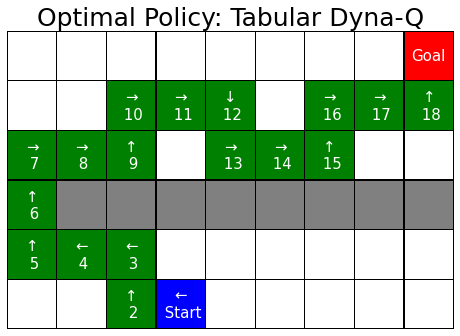

Environment has been just changed!!
Final optimal policy for the new environment


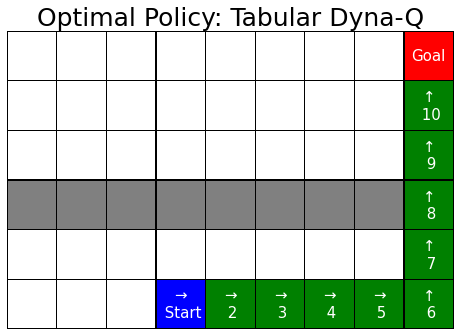

In [6]:
model1 = Model()
actions=[(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8)]
Env1 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                   actions = actions, maze_walls = Maze_walls)
result_1 = Maze(Env = Env1, Envmodel = model1, eps = .15, gamma= .95, 
                n_iters = 200, n_planning_steps = 50, change_step = 2000)
print(colored('Final optimal policy for the new environment', 'blue'))
result_1.plot_optimal_policy()

### Optimal policies using Dyna-Q+

Plot obtained optimal policy after 2000 time steps!!


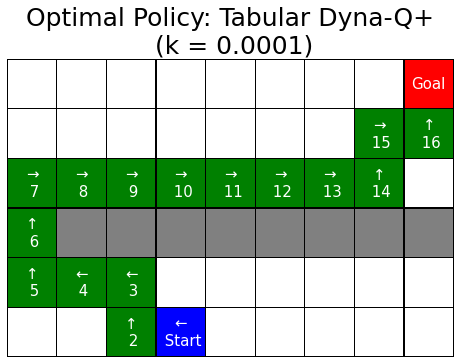

Environment has been just changed!!
Final optimal policy for the new environment


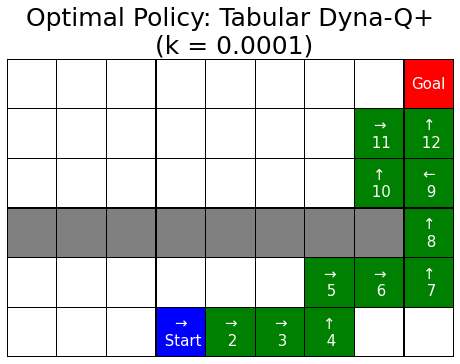

In [7]:
model2 = Model()
actions = [(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8)]
Env2 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                   actions = actions, maze_walls = Maze_walls)
result_2 = Maze(Env = Env2, Envmodel = model2, eps = 0, gamma= .95, 
                n_iters = 200, n_planning_steps = 50, Type = 'Dyna-Q+', 
                k = 0.0001,  change_step = 2000)
print(colored('Final optimal policy for the new environment', 'blue'))
result_2.plot_optimal_policy()

### Optimal policies using New Dyna-Q+

Plot obtained optimal policy after 2000 time steps!!


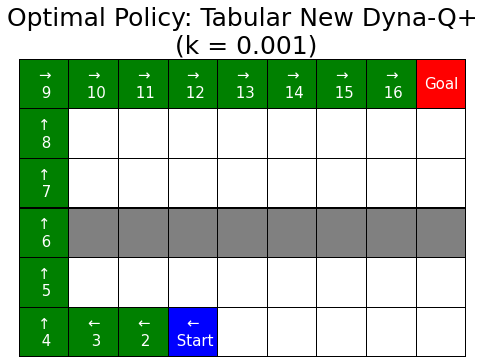

Environment has been just changed!!
Final optimal policy for the new environment


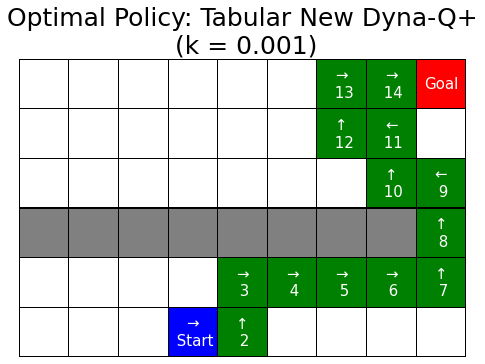

In [8]:
model3 = Model()
actions = [(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8)]
Env3 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                   actions = actions, maze_walls = Maze_walls)
result_3 = Maze(Env = Env3, Envmodel = model3, eps = 0, gamma= .95, 
                n_iters = 200, n_planning_steps = 50, 
                Type = 'New Dyna-Q+', k = 0.001,  change_step = 2000)
print(colored('Final optimal policy for the new environment', 'blue'))
result_3.plot_optimal_policy()

### Comparig average performance of Dyna-Q, Dyna-Q+, and new Dyna-Q+ agents  on Blocking maze task

In [9]:
actions = [(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8)]
history1 = np.zeros(3000)
history2 = np.zeros(3000)
history3 = np.zeros(3000)
change_step = 1000
n_intrs = 30

for i in range(n_intrs):
    model = Model()
    Env1 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                      actions = actions, maze_walls = Maze_walls.copy())
    result_1 = Maze(Env = Env1, Envmodel = model1, eps = .15, gamma= .95, 
                    n_iters = 200, n_planning_steps = 50,  
                    change_step = change_step, plot = False)
    history1 +=  np.array(result_1.reward_history[:3000])


    model = Model()
    Env2 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                 actions = actions, maze_walls = Maze_walls.copy())
    result_2 = Maze(Env = Env2, Envmodel = model, eps = 0, gamma= .95, 
                    n_iters = 200, n_planning_steps = 50, Type = 'Dyna-Q+', 
                    k = 0.001, change_step = change_step, plot = False)
    history2 +=  np.array(result_2.reward_history[:3000])


    model = Model()
    Env3 = Environment(size = (6,9), startpoint = (5,3), endpoint = (0,8), 
                      actions = actions, maze_walls = Maze_walls.copy())
    result_3 = Maze(Env = Env3, Envmodel = model, eps = 0, gamma= .95, 
                    n_iters = 220, n_planning_steps = 50, Type = 'New Dyna-Q+', 
                    k = 0.0009,  change_step = change_step, plot = False)
    history3 +=  np.array(result_3.reward_history[:3000])
    

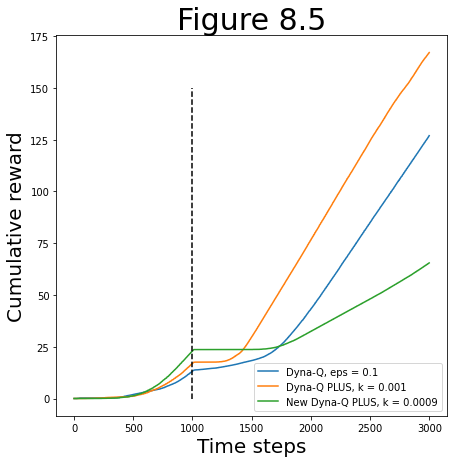

In [10]:
plt.subplots(figsize=(7, 7))

plt.plot(history1/n_intrs, label = 'Dyna-Q, eps = 0.1')
plt.plot(history2/n_intrs, label = 'Dyna-Q PLUS, k = %s' %result_2.k)
plt.plot(history3/n_intrs, label = 'New Dyna-Q PLUS, k = %s' %result_3.k)
plt.plot([change_step, change_step], [0, 150], 'k--')

plt.xlabel('Time steps', fontsize=20)
plt.ylabel('Cumulative reward', fontsize=20)
plt.title('Figure 8.5', fontsize=30)
plt.legend()
plt.show()